In [12]:
pip install entmax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from entmax import Entmax15

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from datetime import timedelta

#### 1. 데이터 불러오기

---

파생 변수 생성 후 데이터 병합

In [1]:
df = pd.read_csv("/content/drive/MyDrive/캡스톤/coffee_oil_exchange_daily.csv")

In [2]:
df.fillna(method='ffill', inplace=True)  # 이전 값으로 대체
df.fillna(method='bfill', inplace=True)  # 다음 값으로 대체

<ipython-input-2-14616036d776>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # 이전 값으로 대체
<ipython-input-2-14616036d776>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # 다음 값으로 대체


In [3]:
df = df[['Date','Coffee_Price', 'Crude_Oil_Price', 'USD_BRL']]

In [4]:
df['Coffee_Price_Return'] = df['Coffee_Price'].pct_change()
df['abs_return'] = df['Coffee_Price_Return'].abs()

# 5일, 10일 변동성 (rolling std)
df['volatility_5d'] = df['Coffee_Price_Return'].rolling(window=5).std()
df['volatility_10d'] = df['Coffee_Price_Return'].rolling(window=10).std()

# 5일 평균 수익률
df['momentum_5d'] = df['Coffee_Price'] - df['Coffee_Price'].shift(5)

# Bollinger Band Width (상대 변동성)
rolling_mean = df['Coffee_Price'].rolling(window=20).mean()
rolling_std = df['Coffee_Price'].rolling(window=20).std()
df['bollinger_width'] = (2 * rolling_std) / rolling_mean

# Return Z-score (비정상 변동 탐지)
df['return_zscore'] = (df['Coffee_Price_Return'] - df['Coffee_Price_Return'].rolling(20).mean()) / \
                       (df['Coffee_Price_Return'].rolling(20).std() + 1e-6)

df['momentum_1d'] = df['Coffee_Price'].diff(1)
df['momentum_3d'] = df['Coffee_Price'].diff(3)
df['volatility_ratio'] = df['volatility_5d'] / df['volatility_10d']

In [5]:
we = pd.read_csv("/content/drive/MyDrive/캡스톤/비수확기평균커피가격통합데이터.csv")

In [6]:
we.drop(columns=['Coffee_Price', 'Coffee_Price_Return','Crude_Oil_Price','USD_KRW','USD_BRL','USD_COP'], inplace=True)

In [7]:
df = pd.merge(df, we, on='Date', how='inner')

In [8]:
df = df.dropna()

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#### 2. train, test 데이터셋 생성

In [10]:
n = len(df)
train_size = int(n * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [14]:
original_train_df = train_df.copy()
original_test_df = test_df.copy()

scaler_seq = StandardScaler()
train_df_scaled = pd.DataFrame(scaler_seq.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
test_df_scaled = pd.DataFrame(scaler_seq.transform(test_df), columns=test_df.columns, index=test_df.index)

train_df_scaled["Coffee_Price_Return"] = original_train_df["Coffee_Price_Return"]
test_df_scaled["Coffee_Price_Return"] = original_test_df["Coffee_Price_Return"]

In [15]:
class MultiStepTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, window_size, horizon, step, static_feat_idx):
        self.data = []
        self.labels = []
        self.static_feats = []

        self.seq_feat_idx = [i for i in range(X.shape[1]) if i not in static_feat_idx]

        for i in range(0, len(X) - window_size - horizon + 1, step):
            x_seq = X[i:i+window_size, self.seq_feat_idx]            # (T, D_seq)
            x_static = X[i, static_feat_idx]                         # (D_static,) 시간에 따라 변하지 않음
            y_target = y[i+window_size:i+window_size+horizon]

            self.data.append(x_seq)
            self.static_feats.append(x_static)
            self.labels.append(y_target)

        self.data = np.array(self.data)
        self.static_feats = np.array(self.static_feats)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x_seq = torch.tensor(self.data[idx], dtype=torch.float32)        # (T, D_seq)
        x_static = torch.tensor(self.static_feats[idx], dtype=torch.float32)  # (D_static,)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)          # (future_target,)
        return x_seq, x_static, y

In [16]:
target_col = "Coffee_Price_Return"

y_train = train_df_scaled[target_col].values
y_test = test_df_scaled[target_col].values

X_train = train_df_scaled.drop(columns=[target_col]).values
X_test = test_df.drop(columns=[target_col]).values

In [17]:
data_window = 100  # 최근 데이터를 입력으로 사용
future_target = 7  # 14개 미래 값 예측
step = 1  # 단위로 샘플링

In [18]:
static_feat_idx = list(range(X_train.shape[1] - 9, X_train.shape[1]))

train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step, static_feat_idx)
test_dataset = MultiStepTimeSeriesDataset(X_test, y_test, data_window, future_target, step, static_feat_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

#### 3. 모델 정의

In [19]:
def compute_attention_entropy(attn_weights):
    eps = 1e-8
    entropy = -torch.sum(attn_weights * torch.log(attn_weights + eps), dim=1)  # (B,)
    return entropy.mean().item()

In [20]:
class EntmaxAttention(nn.Module):
    def __init__(self, hidden_size, attn_dim=64):
        super().__init__()
        self.score_layer = nn.Sequential(
            nn.Linear(hidden_size, attn_dim),
            nn.Tanh(),
            nn.Linear(attn_dim, 1)
        )
        self.entmax = Entmax15(dim=1)

    def forward(self, lstm_output):
        # lstm_output: (B, T, H)
        scores = self.score_layer(lstm_output).squeeze(-1)  # (B, T)
        weights = self.entmax(scores)  # sparse attention weights
        context = torch.sum(lstm_output * weights.unsqueeze(-1), dim=1)  # (B, H)
        return context, weights

In [21]:
class AttentionLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, target_size=14, dropout=0.1, static_feat_dim=9):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_size = target_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

        self.attention = EntmaxAttention(hidden_size)

        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_feat_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, target_size)
        )

    def forward(self, x_seq, x_static, hidden_states=None):
        batch_size = x_seq.size(0)

        if hidden_states is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x_seq.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x_seq.device)
            hidden_states = (h0, c0)

        lstm_out, _ = self.lstm(x_seq, hidden_states)  # (B, T, H)

        context, attn_weights_list = self.attention(lstm_out)  # (B, H), list of (B, T)
        last_hidden = lstm_out[:, -1, :]  # (B, H)

        combined = torch.cat([context, last_hidden], dim=1)  # (B, 2H)
        alpha = self.gate(combined)  # (B, 1)
        fused = alpha * context + (1 - alpha) * last_hidden  # (B, H)

        fused_with_static = torch.cat([fused, x_static], dim=1)
        out = self.fc(fused_with_static)  # (B, target_size)

        return out, attn_weights_list

#### 4. 모델 학습

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_seq, x_static, _ = train_dataset[0]

input_size = x_seq.shape[1]
static_feat_dim = x_static.shape[0]
target_size = 7
model = AttentionLSTMModel(input_size=input_size, target_size=target_size, static_feat_dim=9).to(device)
base_criterion = nn.MSELoss()

# 방향성 손실
def directional_loss(y_pred, y_true):
    pred_diff = torch.sign(y_pred[:, 1:] - y_pred[:, :-1])
    true_diff = torch.sign(y_true[:, 1:] - y_true[:, :-1])
    return torch.mean((pred_diff != true_diff).float())

# 분산 차이 손실
def variance_loss(y_pred, y_true):
    return torch.abs(torch.std(y_pred) - torch.std(y_true))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10)

In [23]:
num_epochs = 20
train_losses = []
test_losses = []

alpha = 0.2  # 방향성 손실 가중치
beta = 0.1  # 분산 손실 가중치

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

        # 예측/실제 저장 (통계용)
    all_train_preds = []
    all_train_targets = []

    for batch_idx, (x_seq, x_static, y_batch) in enumerate(train_loader):
        x_seq = x_seq.to(device)          # (B, T, D_seq)
        x_static = x_static.to(device)    # (B, D_static)
        y_batch = y_batch.to(device)      # (B, target_size)

        optimizer.zero_grad()
        y_pred, _ = model(x_seq, x_static)

        if y_pred.ndim == 3 and y_pred.shape[-1] == 1:
            y_pred = y_pred.squeeze(-1)

        # 예측값/실제값 수집
        all_train_preds.append(y_pred.detach().cpu())
        all_train_targets.append(y_batch.detach().cpu())

        base_loss = base_criterion(y_pred, y_batch)
        dir_loss = directional_loss(y_pred, y_batch)
        var_loss = variance_loss(y_pred, y_batch)
        loss = base_loss + alpha * dir_loss + beta * var_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

        # === 예측값 로그 ===
    all_train_preds_tensor = torch.cat(all_train_preds, dim=0)
    all_train_targets_tensor = torch.cat(all_train_targets, dim=0)

    y_pred_mean = all_train_preds_tensor.mean().item()
    y_pred_std = all_train_preds_tensor.std().item()
    y_true_mean = all_train_targets_tensor.mean().item()
    y_true_std = all_train_targets_tensor.std().item()

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test_seq, x_test_static, y_test in test_loader:
            x_test_seq = x_test_seq.to(device)
            x_test_static = x_test_static.to(device)
            y_test = y_test.to(device)

            y_test_pred, _ = model(x_test_seq, x_test_static)

            if y_test_pred.ndim == 3 and y_test_pred.shape[-1] == 1:
                y_test_pred = y_test_pred.squeeze(-1)

            base_test_loss = base_criterion(y_test_pred, y_test)
            dir_test_loss = directional_loss(y_test_pred, y_test)
            var_test_loss = variance_loss(y_test_pred, y_test)
            total_test_loss = base_test_loss + alpha * dir_test_loss + beta * var_test_loss

            test_loss += total_test_loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    scheduler.step(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_test_loss:.4f} | "
          f"y_pred mean: {y_pred_mean:.4f}, std: {y_pred_std:.4f} | "
          f"y_true mean: {y_true_mean:.4f}, std: {y_true_std:.4f}")

Epoch [1/20] | Train Loss: 0.1116 | Val Loss: 0.1419 | y_pred mean: 0.0240, std: 0.0661 | y_true mean: 0.0004, std: 0.0190
Epoch [2/20] | Train Loss: 0.1010 | Val Loss: 0.1457 | y_pred mean: -0.0002, std: 0.0186 | y_true mean: 0.0004, std: 0.0190
Epoch [3/20] | Train Loss: 0.1027 | Val Loss: 0.1424 | y_pred mean: 0.0007, std: 0.0178 | y_true mean: 0.0004, std: 0.0190
Epoch [4/20] | Train Loss: 0.1020 | Val Loss: 0.1379 | y_pred mean: 0.0005, std: 0.0182 | y_true mean: 0.0004, std: 0.0190
Epoch [5/20] | Train Loss: 0.1026 | Val Loss: 0.1590 | y_pred mean: 0.0016, std: 0.0185 | y_true mean: 0.0004, std: 0.0190
Epoch [6/20] | Train Loss: 0.1024 | Val Loss: 0.1287 | y_pred mean: 0.0000, std: 0.0186 | y_true mean: 0.0004, std: 0.0190
Epoch [7/20] | Train Loss: 0.1026 | Val Loss: 0.1428 | y_pred mean: 0.0006, std: 0.0184 | y_true mean: 0.0004, std: 0.0190
Epoch [8/20] | Train Loss: 0.1029 | Val Loss: 0.1364 | y_pred mean: 0.0003, std: 0.0184 | y_true mean: 0.0004, std: 0.0190
Epoch [9/20] | 

#### 5. 모델 학습 결과 확인

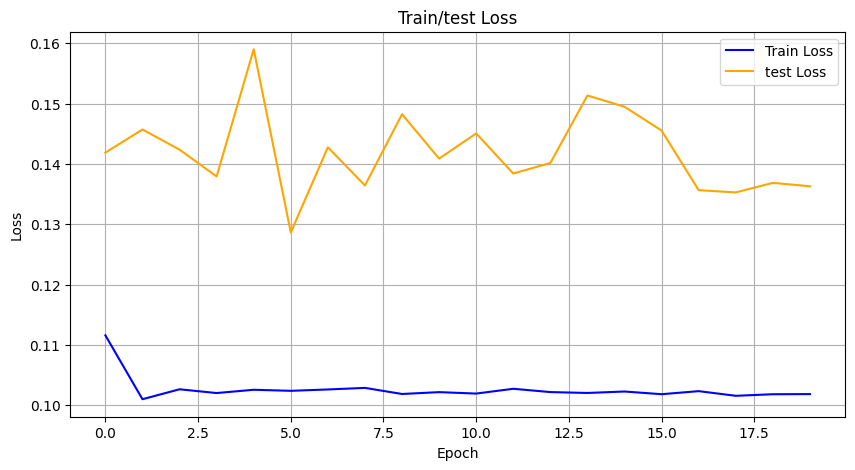

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/test Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
with torch.no_grad():
    # 1개 샘플 선택 (배치 차원 유지)
    sample_seq, sample_static, _ = train_dataset[0]
    sample_seq = sample_seq.unsqueeze(0).to(device)       # (1, T, D_seq)
    sample_static = sample_static.unsqueeze(0).to(device) # (1, D_static)

    _, attn_weights = model(sample_seq, sample_static)

    # 리스트 형태로 반환된 경우 대응
    if isinstance(attn_weights, list):
        # 리스트 안에 하나의 tensor만 있을 경우
        if len(attn_weights) == 1:
            attn_tensor = attn_weights[0]
        else:
            # 여러 tensor라면 평균으로 합성
            attn_tensor = torch.stack(attn_weights).mean(dim=0)
    else:
        attn_tensor = attn_weights  # 이미 tensor라면 그대로

    print("Attention std:", attn_tensor.std().item())
    print("Attention weights:", attn_tensor)

Attention std: 0.000730508123524487
Attention weights: tensor([[0.0069, 0.0078, 0.0085, 0.0092, 0.0094, 0.0094, 0.0094, 0.0093, 0.0091,
         0.0090, 0.0090, 0.0091, 0.0092, 0.0093, 0.0093, 0.0093, 0.0093, 0.0094,
         0.0096, 0.0098, 0.0101, 0.0103, 0.0105, 0.0105, 0.0104, 0.0103, 0.0100,
         0.0098, 0.0097, 0.0096, 0.0094, 0.0096, 0.0098, 0.0100, 0.0102, 0.0102,
         0.0101, 0.0100, 0.0100, 0.0097, 0.0092, 0.0089, 0.0086, 0.0089, 0.0093,
         0.0097, 0.0101, 0.0105, 0.0105, 0.0101, 0.0099, 0.0097, 0.0097, 0.0099,
         0.0102, 0.0103, 0.0104, 0.0106, 0.0105, 0.0106, 0.0106, 0.0108, 0.0111,
         0.0111, 0.0110, 0.0108, 0.0107, 0.0106, 0.0105, 0.0103, 0.0100, 0.0098,
         0.0098, 0.0102, 0.0106, 0.0108, 0.0109, 0.0109, 0.0107, 0.0104, 0.0106,
         0.0110, 0.0110, 0.0109, 0.0106, 0.0101, 0.0097, 0.0100, 0.0105, 0.0107,
         0.0109, 0.0110, 0.0108, 0.0105, 0.0101, 0.0099, 0.0099, 0.0100, 0.0104,
         0.0106]])


In [26]:
input_seq1, static_feat1, y_true1 = test_dataset[0]
input_seq2, static_feat2, y_true2 = test_dataset[10]

# 배치 차원 추가 (B=1)
input_seq1 = input_seq1.unsqueeze(0).to(device)
input_seq2 = input_seq2.unsqueeze(0).to(device)
static_feat1 = static_feat1.unsqueeze(0).to(device)
static_feat2 = static_feat2.unsqueeze(0).to(device)

# 모델 호출 시 두 인자 모두 전달
out1, _ = model(input_seq1, static_feat1)
out2, _ = model(input_seq2, static_feat2)

print("Prediction difference:", torch.norm(out1 - out2).item())

Prediction difference: 0.001137364306487143


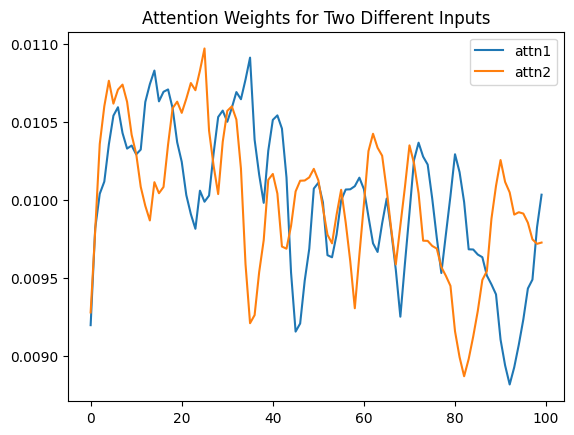

In [27]:
_, attn1 = model(input_seq1, static_feat1)
_, attn2 = model(input_seq2, static_feat2)

plt.plot(attn1.squeeze().detach().cpu(), label='attn1')
plt.plot(attn2.squeeze().detach().cpu(), label='attn2')
plt.legend()
plt.title("Attention Weights for Two Different Inputs")
plt.show()

In [28]:
with torch.no_grad():
    out, _ = model.lstm(sample_seq)
    std_across_time = out.std(dim=1).mean().item()
    print("LSTM output std (across time steps):", std_across_time)

LSTM output std (across time steps): 0.01952633261680603


In [29]:
with torch.no_grad():
    # batch 차원 추가
    x_seq, x_static, _ = test_dataset[0]
    x_seq = x_seq.unsqueeze(0).to(device)      # (1, T, D_seq)

    # LSTM 통과
    lstm_out, _ = model.lstm(x_seq)            # (1, T, H)

    # Attention 적용
    context1, _ = model.attention(lstm_out)    # (1, H)
    last_hidden1 = lstm_out[:, -1, :]          # (1, H)

    print("context1 norm:", torch.norm(context1).item())
    print("last_hidden1 norm:", torch.norm(last_hidden1).item())

context1 norm: 0.9034490585327148
last_hidden1 norm: 0.8968192338943481


#### 5. 예측 및 실제값과의 비교

In [30]:
model.eval()
predictions = []
prediction_dates_list = []

return_col = "Coffee_Price_Return"
price_col = "Coffee_Price"
return_idx = train_df.columns.get_loc(return_col)

with torch.no_grad():
    for batch_idx, (x_seq, x_static, _) in enumerate(test_loader):
        x_seq = x_seq.to(device)         # (B, T, D_seq)
        x_static = x_static.to(device)   # (B, D_static)
        batch_size = x_seq.size(0)

        # 모델 예측
        y_pred_batch, _ = model(x_seq, x_static)  # (B, future_target)
        y_pred_batch = y_pred_batch.cpu().numpy()

        for i in range(batch_size):
            y_pred = y_pred_batch[i].reshape(-1)  # (future_target,)

            # 역정규화를 위한 dummy 입력 생성 (수익률 기준)
            dummy = np.zeros((future_target, len(train_df.columns)))
            dummy[:, return_idx] = y_pred
            return_inv = scaler_seq.inverse_transform(dummy)[:, return_idx]

            # 글로벌 인덱스 계산
            global_idx = (batch_idx * test_loader.batch_size + i) * step + data_window
            if global_idx + future_target >= len(test_df):
                break

            # 예측 시점의 시작 가격 확보
            start_timestamp = test_df.index[global_idx]
            start_pos_in_df = df.index.get_loc(start_timestamp)

            # 이전 실제 가격 확보 (return 기반 price 복원 시 기준점)
            try:
                start_price = df[price_col].iloc[start_pos_in_df]
            except IndexError:
                continue  # index out of bounds

            # 미래 날짜 범위 확보
            date_range = df.index[start_pos_in_df + 1 : start_pos_in_df + 1 + future_target]
            if len(date_range) != future_target:
                continue

            # 실제 가격 복원: 누적 수익률 기반
            price_pred = [start_price]
            for r in return_inv:
                price_pred.append(price_pred[-1] * (1 + r))
            price_pred = price_pred[1:]  # 첫 원소는 시작값이므로 제외

            predictions.append(pd.Series(price_pred, index=date_range))
            prediction_dates_list.extend(date_range)

In [31]:
all_preds = pd.concat(predictions)
print("Min prediction:", all_preds.min())
print("Max prediction:", all_preds.max())

Min prediction: 145.39607873755182
Max prediction: 441.39101161456466


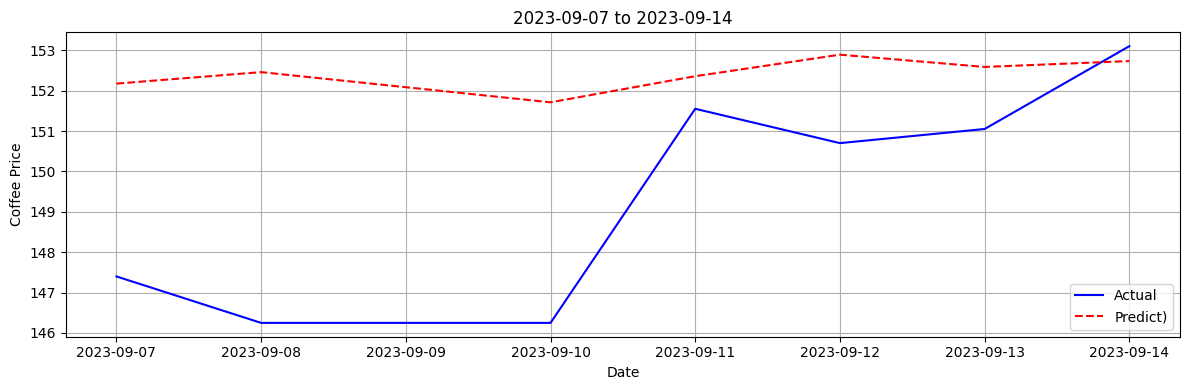

In [32]:
k = 10
pred_k = predictions[k]  # 반드시 먼저 정의

# 실제값: 예측값과 동일한 index로 추출
true_k = df['Coffee_Price'].reindex(pred_k.index)


# 시각화
plt.figure(figsize=(12, 4))
plt.plot(true_k.index, true_k.values, label='Actual', color='blue')
plt.plot(pred_k.index, pred_k.values, label='Predict)', color='red', linestyle='dashed')
plt.title(f"{true_k.index[0].date()} to {true_k.index[-1].date()}")
plt.xlabel("Date")
plt.ylabel("Coffee Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

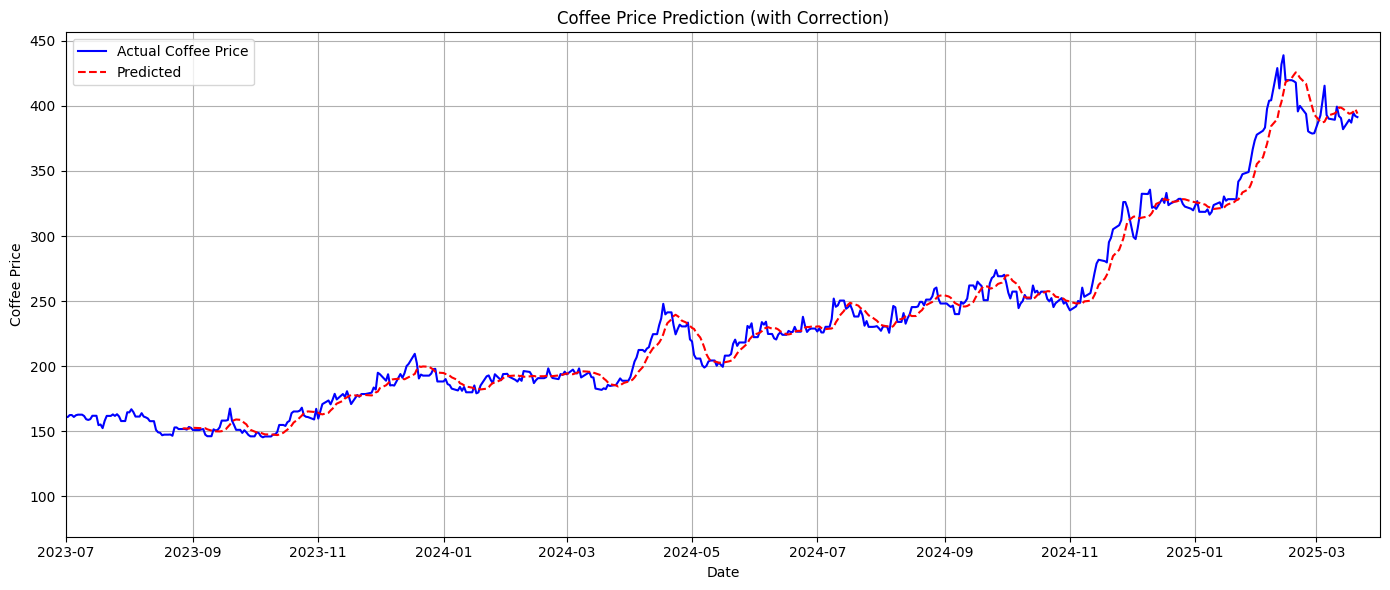

In [33]:
forecast_all = pd.concat(predictions, axis=1).mean(axis=1)  # 날짜 기준 평균 예측

plt.figure(figsize=(14, 6))
plt.plot(df['Coffee_Price'], label='Actual Coffee Price', color='blue')
plt.plot(forecast_all.index, forecast_all.values, label='Predicted', color='red', linestyle='dashed')
plt.title('Coffee Price Prediction (with Correction)')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.xlim(pd.to_datetime('2023-07-01'), pd.to_datetime('2025-04-01'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

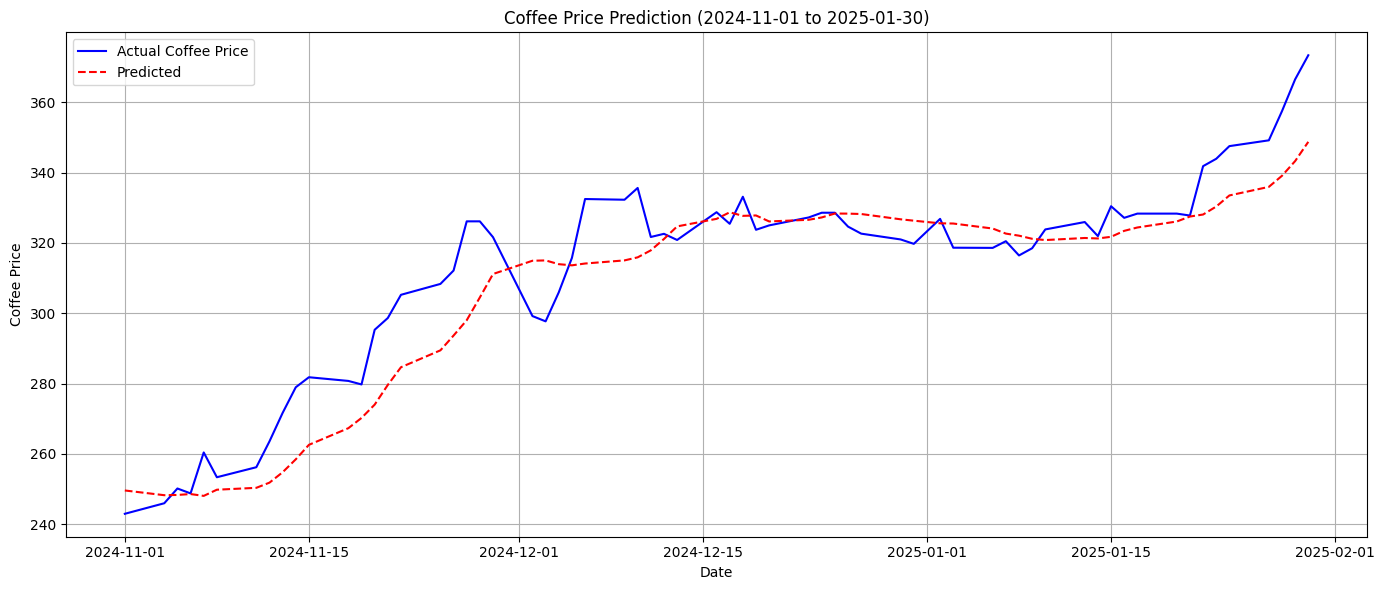

In [36]:
# 지정 기준 날짜
selected_date = pd.to_datetime("2024-11-01")

start_date = selected_date
end_date = selected_date + pd.Timedelta(days=90)

forecast_all = pd.concat(predictions, axis=1).mean(axis=1)

plt.figure(figsize=(14, 6))
plt.plot(df['Coffee_Price'].loc[start_date:end_date], label='Actual Coffee Price', color='blue')
plt.plot(forecast_all.loc[start_date:end_date].index, forecast_all.loc[start_date:end_date].values,
         label='Predicted', color='red', linestyle='dashed')
plt.title(f'Coffee Price Prediction ({start_date.date()} to {end_date.date()})')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
# 예측과 동일한 index를 가진 실제 가격 시계열 리스트 만들기
true_series_list = []

for pred_k in predictions:
    date_range = pred_k.index
    true_k = df['Coffee_Price'].reindex(date_range)
    true_series_list.append(true_k)

#### 6. 모델 성능 평가

---

+-10원 정도의 오차 있음

In [35]:
actual = df.loc[forecast_all.index, 'Coffee_Price']

predicted = forecast_all

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

RMSE: 9.1426
MAE:  6.6435


#### 7. 앞으로의 2주간 가격 흐름 확인

In [37]:
all_columns = train_df_scaled.drop(columns=[target_col]).columns.tolist()

static_columns = [all_columns[i] for i in static_feat_idx]
seq_columns = [col for col in all_columns if col not in static_columns]

x_seq_input = test_df.iloc[-data_window:][seq_columns].values
x_seq_input = torch.tensor(x_seq_input, dtype=torch.float32).unsqueeze(0).to(device)

# 2. 마지막 정적 피처 준비
x_static_input = test_df.iloc[-1][static_columns].values  # (D_static,)
x_static_input = torch.tensor(x_static_input, dtype=torch.float32).unsqueeze(0).to(device)  # (1, D_static)

In [41]:
model.eval()

with torch.no_grad():
    y_pred_future, _ = model(x_seq_input, x_static_input)  # (1, future_target)
    y_pred_future = y_pred_future.squeeze(0).cpu().numpy()  # (future_target,)

dummy = np.zeros((future_target, len(train_df.columns)))
dummy[:, return_idx] = y_pred_future
return_inv = scaler_seq.inverse_transform(dummy)[:, return_idx]

start_price = test_df[price_col].iloc[-1]

price_future = [start_price]
for r in return_inv:
    price_future.append(price_future[-1] * (1 + r))
price_future = price_future[1:]

last_date = test_df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_target, freq='D')

In [42]:
future_price_series = pd.Series(price_future, index=future_dates)
future_price_series

,0
2025-03-22,391.762602
2025-03-23,392.383881
2025-03-24,390.826941
2025-03-25,392.334251
2025-03-26,393.413487
2025-03-27,392.913147
2025-03-28,393.289889


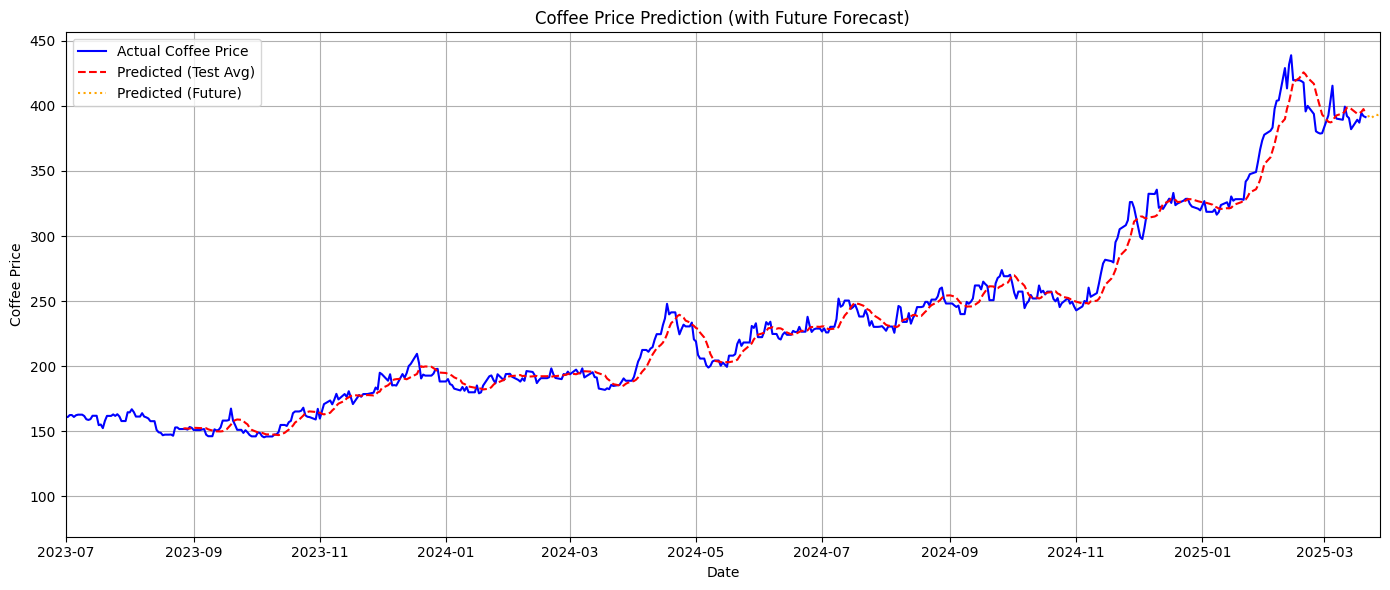

In [43]:
plt.figure(figsize=(14, 6))

plt.plot(df['Coffee_Price'], label='Actual Coffee Price', color='blue')

plt.plot(forecast_all.index, forecast_all.values, label='Predicted (Test Avg)', color='red', linestyle='dashed')

plt.plot(future_price_series.index, future_price_series.values, label='Predicted (Future)', color='orange', linestyle='dotted')

plt.title('Coffee Price Prediction (with Future Forecast)')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.xlim(pd.to_datetime('2023-07-01'), future_price_series.index[-1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

예측결과 csv 파일 생성

In [44]:
pred_series = pd.concat(predictions).sort_index()

true_series = pd.Series(df['Coffee_Price'], index=pred_series.index)  # 인덱스는 동일한 date_ranges 기반

result_df = pd.DataFrame({
    "Date": pred_series.index,
    "Predicted_Price": pred_series.values,
    "Actual_Price": true_series.values
})

result_df["Date"] = pd.to_datetime(result_df["Date"])

result_df = result_df.sort_values("Date").reset_index(drop=True)

In [45]:
future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Price": price_future,
    "Actual_Price": [None] * len(price_future)  # 미래 구간은 실제값 없음
})

In [46]:
full_df = pd.concat([result_df, future_df], ignore_index=True)

<ipython-input-46-1a2efe24f354>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([result_df, future_df], ignore_index=True)


In [48]:
full_df.to_csv("coffee_price_prediction_7days.csv", index=False)